In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd

from skimage.measure import label
from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure

from PIL import Image
import cv2

In [50]:
# Read pandas files
# Read the compressed CSV file

#directory = 'odd_output_singleMu_1000'
directory = 'odd_output_ttbar_PU200_100'

particles = pd.read_csv(directory+'/particles_initial.csv.gz')

# Display the DataFrame
print(particles.head())

spacepoints = pd.read_csv(directory+'/spacepoints.csv.gz')

# Display the DataFrame
print(spacepoints.head())



   event_id       particle_id  particle_type  process        vx        vy  \
0         0  4503599711256576            211        0 -0.006878  0.006443   
1         0  4503599728033792           -211        0 -0.006878  0.006443   
2         0  4503599744811008           -211        0 -0.006878  0.006443   
3         0  4503599761588224            211        0 -0.006878  0.006443   
4         0  4503599778365440           -211        0 -0.006878  0.006443   

          vz        vt        px         py  ...    q       eta       phi  \
0  26.299278  6.842251 -0.190902   0.241511  ...  1.0  1.538281  2.239685   
1  26.299278  6.842251 -0.931814  -1.761880  ... -1.0 -2.150238 -2.057276   
2  26.299278  6.842251 -0.229023  13.005651  ... -1.0  0.689218  1.588404   
3  26.299278  6.842251  0.166807   3.399969  ...  1.0  0.769163  1.521774   
4  26.299278  6.842251 -0.161747   5.822194  ... -1.0  0.713915  1.598570   

          pt          p  vertex_primary  vertex_secondary  particle  \
0  

In [51]:

# Parameters
np.random.seed(3)  # For reproducibility

num_events = 1000000
num_events = min(np.max(particles['event_id']),num_events)
print(" num_events: ",num_events)

#num_tracks = 15
#detector_layers = 9
#phi_min = -0.8 #-0.29 #-1 * np.pi #-0.29 #-1 * np.pi
#phi_max = 0.0 #-0.27 # 1 * np.pi #1 * np.pi
#phi_sigma = 0.001
#n_points = 1
curv_max = 0.00120 #0.02
#radii = np.linspace(10, 90, detector_layers)

hough_space_size_v = 256
hough_space_size_h = 256
nthick = 3#3  # line thickness in accumulator

small_size = 32 # window size
tollerance = 8  # tollerance to classify a window as containing the true maximum
height = 3 #threshold to find maxima
zero_limit = 0#7 #anything smaller is set to zero in accumulator

A = 0.00029 # curvature = A * 1/pt 

img_norm = 20.  # image normalization

eta_min = -0.2#-2.1
eta_max =  0.2#2.1
vz_min  = -100#-70
vz_max  =  100#70

R_max   =  2000 # max R of a hit
Z_max   =  200 # max Z of  hit

vz_tol =  2 #50
eta_tol = 0.02 #0.001
phi_tol = 0.1  #0.1


 num_events:  19


In [52]:
'''
# Function to generate curved tracks
def generate_curved_tracks(num_tracks, radii):
    tracks = []
    track_par = []
    for _ in range(num_tracks):
        curvature = np.random.uniform(-curv_max, curv_max)  # Random curvature based on momentum
        angle = np.random.uniform(phi_min+0.1*(phi_max-phi_min), phi_max-0.1*(phi_max-phi_min))
        hits = [(radius * np.cos(angle+np.random.normal(0,phi_sigma) + curvature * radius),
                 radius * np.sin(angle+np.random.normal(0,phi_sigma) + curvature * radius)) for radius in radii]
        tracks.append(hits)
        track_par.append([angle,curvature])
        #print(curvature, angle)
    return tracks, track_par

# Generate tracks
tracks, track_par = generate_curved_tracks(num_tracks, radii)
#print(tracks)
'''

'\n# Function to generate curved tracks\ndef generate_curved_tracks(num_tracks, radii):\n    tracks = []\n    track_par = []\n    for _ in range(num_tracks):\n        curvature = np.random.uniform(-curv_max, curv_max)  # Random curvature based on momentum\n        angle = np.random.uniform(phi_min+0.1*(phi_max-phi_min), phi_max-0.1*(phi_max-phi_min))\n        hits = [(radius * np.cos(angle+np.random.normal(0,phi_sigma) + curvature * radius),\n                 radius * np.sin(angle+np.random.normal(0,phi_sigma) + curvature * radius)) for radius in radii]\n        tracks.append(hits)\n        track_par.append([angle,curvature])\n        #print(curvature, angle)\n    return tracks, track_par\n\n# Generate tracks\ntracks, track_par = generate_curved_tracks(num_tracks, radii)\n#print(tracks)\n'

In [53]:
'''
# Plot the generated tracks
def plot_tracks(tracks):
    def plot_partial_circle(R, phi_min, phi_max):
        phi = np.linspace(phi_min, phi_max, 100)  # Create an array of angles from phi_min to phi_max
        x = R * np.cos(phi)
        y = R * np.sin(phi)

        plt.plot(x, y, color="black", label=f'Radius = {R}, ${phi_min} < \\phi < {phi_max}$')


    fig, ax = plt.subplots(figsize=(8,8))
    #plot layers
    for R in radii:
        plot_partial_circle(R, phi_min - 1.5*(phi_max-phi_min), phi_max + 1.5*(phi_max-phi_min))
    #plot tracks
    for hits in tracks:
        x, y = zip(*hits)
        ax.plot(x, y, 'o-')
    ax.set_aspect('equal')
    ax.set_title("Generated Curved Tracks in 2D Detector")

    plt.plot(0,0,'o',color="black")
    plt.show()
    
plot_tracks(tracks)    
'''

'\n# Plot the generated tracks\ndef plot_tracks(tracks):\n    def plot_partial_circle(R, phi_min, phi_max):\n        phi = np.linspace(phi_min, phi_max, 100)  # Create an array of angles from phi_min to phi_max\n        x = R * np.cos(phi)\n        y = R * np.sin(phi)\n\n        plt.plot(x, y, color="black", label=f\'Radius = {R}, ${phi_min} < \\phi < {phi_max}$\')\n\n\n    fig, ax = plt.subplots(figsize=(8,8))\n    #plot layers\n    for R in radii:\n        plot_partial_circle(R, phi_min - 1.5*(phi_max-phi_min), phi_max + 1.5*(phi_max-phi_min))\n    #plot tracks\n    for hits in tracks:\n        x, y = zip(*hits)\n        ax.plot(x, y, \'o-\')\n    ax.set_aspect(\'equal\')\n    ax.set_title("Generated Curved Tracks in 2D Detector")\n\n    plt.plot(0,0,\'o\',color="black")\n    plt.show()\n    \nplot_tracks(tracks)    \n'

In [54]:
'''
# Hough transform

def hough_track(tracks):
    
    # Define the grid for the histogram
    x_bins = np.linspace(phi_min, phi_max, hough_space_size+1)
    y_bins = np.linspace(-2*curv_max, 2*curv_max, hough_space_size+1)
    
    lines=[]
    for tr in tracks:

        # here we generate one thick line
        for ht in tr:
            rh = np.sqrt(ht[0]*ht[0]+ht[1]*ht[1])
            phih = np.arctan2(ht[1], ht[0])
            
            lphi = -phih/rh
            
            line = np.zeros((1,2))
            # Assign values
            line[:, 1] = 1 / rh
            line[:, 0] = lphi
            # Convert to a list of arrays
            lines.extend([line[k] for k in range(line.shape[0])])            
         

    #print(len(lines))        
            
    # fill a histogram of points, the hough_space accumulator
    points = []
'''
'''
    # here we generate many lines
    for ll in lines:
        iphi = np.linspace(phi_min, phi_max, hough_space_size)  #*n_points
        icurv = ll[1]*(iphi) + ll[0] # + np.random.normal(0, phi_sigma, hough_space_size*n_points)
        points.extend(list(zip(iphi, icurv)))  # Store (x, y) points
    points = np.array(points)  # Convert to numpy array
'''
'''
    # here a single line with thicknes nthick
    for ll in lines:
        iphi = np.linspace(phi_min, phi_max, hough_space_size) 
        for nn in range(-nthick // 2, nthick //2):
            icurv = ll[1]*(iphi) + ll[0] + 2*nn * (2*curv_max)/hough_space_size
            points.extend(list(zip(iphi, icurv)))  # Store (x, y) points
    points = np.array(points)  # Convert to numpy array
     
'''
'''
    # Define the grid for the histogram
    x_bins = np.linspace(phi_min, phi_max, hough_space_size+1)
    y_bins = np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), hough_space_size+1)
    print("y_bins = ",np.min(points[:, 1]), np.max(points[:, 1]))
'''
'''    
    hough_space, x_edges, y_edges = np.histogram2d(points[:, 0], points[:, 1], bins=[x_bins, y_bins])     
            
    return lines, hough_space, x_edges, y_edges  

lines, hough_space_hist, x_edges, y_edges = hough_track(tracks)
'''

'    \n    hough_space, x_edges, y_edges = np.histogram2d(points[:, 0], points[:, 1], bins=[x_bins, y_bins])     \n            \n    return lines, hough_space, x_edges, y_edges  \n\nlines, hough_space_hist, x_edges, y_edges = hough_track(tracks)\n'

In [55]:

# fill Hough accumulator

def hough_track(spacepoints, n_event, phi, eta, vz):
        
    lines=[]
    
    # Select rows by event number
    spacepoints_sel = spacepoints[spacepoints['event_id'] == n_event]
    
    for row in spacepoints_sel.itertuples():
        hx = row.x
        hy = row.y
        hz = row.z

        rh = np.sqrt(hx*hx+hy*hy)
        phih = np.arctan2(hy, hx)
        
        #if (rh) > R_max or abs(hz) > Z_max:
        if (rh) > R_max or abs(hz) > Z_max:
            continue
        #print("rh, hz: ",rh, hz)

        lphi = -phih/rh

        #generate Hough line only if a hit is within a vz_tol, eta_tol, and 2*phi_tol to the track
        #\eta = -=ln [tan (\theta / 2)]
        # \theta = 2* arctan(exp(-\eta))
        theta_min = 2*np.arctan(np.exp(-(eta+eta_tol)))
        theta_max = 2*np.arctan(np.exp(-(eta-eta_tol)))
        z_min = vz-vz_tol+rh/np.tan(theta_max)
        z_max = vz+vz_tol+rh/np.tan(theta_min)
        #print("z_min, z_max: ",z_min, z_max)
        #print("z range: ",vz,rh/np.tan(2*np.arctan(np.exp(-(eta)))),2*np.arctan(np.exp(-(eta)))  )
        #print("zzz range: ",z_min,z_max,hz,2*np.arctan(np.exp(-(eta))))
        #print(eta, 2*np.arctan(np.exp(-(eta)))-np.pi/2.)
        #print("theta_min, theta_max, z_min, z_max, hz: ",theta_min, theta_max,z_min, z_max, hz)
        if (hz > z_min) and (hz < z_max): 
            #print("theta_min, theta_max, z_min, z_max, hz: ",theta_min, theta_max,z_min, z_max, hz)
            line = np.zeros((1,2))
            # Assign values
            line[:, 1] = 1 / rh
            line[:, 0] = lphi
            # Convert to a list of arrays
            lines.extend([line[k] for k in range(line.shape[0])])            
         

    #print(len(lines))        
            
    # fill a histogram of points, the hough_space accumulator
    points = []
    
    
    # Define the grid for the histogram
    phi_min = phi - phi_tol
    phi_max = phi + phi_tol
    x_bins = np.linspace(phi_min, phi_max, hough_space_size_h+1)
    y_bins = np.linspace(-curv_max, curv_max, hough_space_size_v+1)
    
    # here a single line with thicknes nthick
    '''
    for ll in lines:
        iphi = np.linspace(phi_min, phi_max, hough_space_size_h) 
        for nn in range(-nthick // 2, nthick //2):
            icurv = ll[1]*(iphi) + ll[0] + 2*nn * (2*curv_max)/hough_space_size_v
            points.extend(list(zip(iphi, icurv)))  # Store (x, y) points
    points = np.array(points)  # Convert to numpy array
         
    if len(points) == 0:
        # Let numpy compute the edges for empty data (will be based purely on bins parameter)
        hough_space, x_edges, y_edges = np.histogram2d([], [], bins=[x_bins, y_bins])
    else:
        hough_space, x_edges, y_edges = np.histogram2d(points[:, 0], points[:, 1], bins=[x_bins, y_bins])
     
    #hough_space, x_edges, y_edges = np.histogram2d(points[:, 0], points[:, 1], bins=[x_bins, y_bins])   
    '''
    for ll in lines:
        points_array = np.zeros((hough_space_size_h, hough_space_size_v))
        y0 = (ll[1]*(phi_min) + ll[0] + curv_max)/(2.*curv_max)*hough_space_size_v
        y1 = (ll[1]*(phi_max) + ll[0] + curv_max)/(2.*curv_max)*hough_space_size_v
        #print("y0, y1: ",y0, y1)
       
        cv2.line(points_array, (int(y0), 0), (int(y1), hough_space_size_h-1), 1, thickness=nthick, lineType=cv2.LINE_AA)
        #plt.imshow(points_array)
        #plt.show()
        
        pp = np.argwhere(points_array>0)
        # Multiply colums by factors to get back phi and curv
        pp = pp * [(phi_max-phi_min)/hough_space_size_h, 2*curv_max/hough_space_size_v]+[phi_min, -curv_max]  # Element-wise multiplication
        #print("pp: ",pp.shape,pp[0:1,:])
        points.append(pp)
    # Stack all arrays at once after the loop
    if len(points) > 0:
        points = np.vstack(points)    
    #print("points: ",points.shape)
    #print(points[0:10,:])
    
         
    if len(points) == 0:
        # Let numpy compute the edges for empty data (will be based purely on bins parameter)
        hough_space, x_edges, y_edges = np.histogram2d([], [], bins=[x_bins, y_bins])
    else:
        hough_space, x_edges, y_edges = np.histogram2d(points[:, 0], points[:, 1], bins=[x_bins, y_bins])        
    
    
    return lines, hough_space, x_edges, y_edges  






In [56]:

# plot hits

def plot_hits(spacepoints, n_event, phi, eta, vz, all=False):
        
    hits_xy = []
    hits_rz = []
    
    # Select rows by event number
    if all:
        spacepoints_sel = spacepoints
    else:    
        spacepoints_sel = spacepoints[spacepoints['event_id'] == n_event]
    
    
    for row in spacepoints_sel.itertuples():
        hx = row.x
        hy = row.y
        hz = row.z

        rh = np.sqrt(hx*hx+hy*hy)
        phih = np.arctan2(hy, hx)
        
        #if (rh) > R_max or abs(hz) > Z_max:
        if (rh) > R_max or abs(hz) > Z_max or phih < phi-phi_tol or phih > phi+phi_tol:
            continue
        #print("rh, hz: ",rh, hz)
        
        theta_min = 2*np.arctan(np.exp(-(eta+eta_tol)))
        theta_max = 2*np.arctan(np.exp(-(eta-eta_tol)))
        z_min = vz-vz_tol+rh/np.tan(theta_max)
        z_max = vz+vz_tol+rh/np.tan(theta_min)
        
        if (hz > z_min) and (hz < z_max): 
            hits_xy.append((hx,hy))
            hits_rz.append((hz,rh))
                           
    # Unzip hits_xy 
    x, y = zip(*hits_xy)  

    fig = plt.figure(figsize=(8, 8))
    # Create scatter plot
    if all:
        plt.scatter(x, y, color='blue',marker="." ,s=1,label='hits')
    else:
        plt.scatter(x, y, color='blue',marker="o" ,label='hits')
    plt.plot(0, 0, color='black',marker="o" ,markersize=12, label='center')
                       

    # Customize the plot
    xlim0=-700
    xlim1= 700
    ylim0=-700
    ylim1= 700
    if (np.min(x)>0):
        xlim0=0
    if (np.max(x)<0):
        xlim1=0
    if (np.min(y)>0):
        ylim0=0
    if (np.max(y)<0):
        ylim1=0    
    plt.xlim(xlim0,xlim1)
    plt.ylim(ylim0,ylim1)
    plt.title('Scatter Plot of Hits')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()
 
    # Unzip hits_rz 
    z, r = zip(*hits_rz)  

    fig = plt.figure(figsize=(8, 8))
    # Create scatter plot
    if all:
        plt.scatter(z, r, color='blue',marker=".", s=1 ,label='hits')
    else:
        plt.scatter(z, r, color='blue',marker="o",label='hits')
    
    # add true track (todo)
    
    # Add line (y = x)
    line_z = np.linspace(min(z), max(z), 100)
    line_r = np.linspace(0, 0, 100)                       
    plt.plot(line_z, line_r, 'g--', label='z-axis')
    #plt.scatter(0, 0, color='black',marker="o" ,s=60,label='center')

    # Customize the plot
    #plt.xlim(-200,200)
    plt.ylim(0,700)
    plt.title('Scatter Plot of Hits')
    plt.xlabel('Z-axis')
    plt.ylabel('R-axis')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()
                           
     

In [57]:

# plot all hits - detector RTG :)

def plot_hits_all(spacepoints):
        
    hits_xy = []
    hits_rz = []
    
    # Select rows by event number
    #spacepoints_sel = spacepoints[spacepoints['event_id'] == n_event]
    spacepoints_sel = spacepoints
    
    for row in spacepoints_sel.itertuples():
        hx = row.x
        hy = row.y
        hz = row.z

        rh = np.sqrt(hx*hx+hy*hy)
        #phih = np.arctan2(hy, hx)
    
        if abs(hz)<500:
            hits_xy.append((hx,hy))
        hits_rz.append((hz,rh))
                           
    # Unzip hits_xy 
    x, y = zip(*hits_xy)  

    fig = plt.figure(figsize=(10, 10))
    # Create scatter plot
    plt.scatter(x, y, color='blue',marker="." ,s=1,label='hits')
    plt.plot(0, 0, color='black',marker="o" ,markersize=12, label='center')
                       

    # Customize the plot

    plt.title('Scatter Plot of Hits')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()
 
    # Unzip hits_rz 
    z, r = zip(*hits_rz)  

    fig = plt.figure(figsize=(8, 8))
    # Create scatter plot
    plt.scatter(z, r, color='blue',marker=".", s=1 ,label='hits')
    
    # add true track (todo)
    
    # Add line (y = x)
    line_z = np.linspace(min(z), max(z), 100)
    line_r = np.linspace(0, 0, 100)                       
    plt.plot(line_z, line_r, 'g--', label='z-axis')
    #plt.scatter(0, 0, color='black',marker="o" ,s=60,label='center')

    # Customize the plot
    plt.title('Scatter Plot of Hits')
    plt.xlabel('Z-axis')
    plt.ylabel('R-axis')
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.show()
                           
     

In [58]:
def true_track(particles, n_event):
    particles_sel = particles[(particles['event_id'] == n_event)]
    #print(particles_sel.head())
    particles_sel = particles_sel[ 
                                (particles['vz']>vz_min) & (particles['vz']<vz_max)
                              & (particles['eta']>eta_min) & (particles['eta']<eta_max)]
    #print(particles_sel.head())
    # Read true track parameters
    true_tracks = np.column_stack((
        particles_sel['phi'],         
        particles_sel['eta'],         
        A/(particles_sel['pt']*particles_sel['q']),      # curvature
        particles_sel['vz']
    ))
    #print("true_tracks:",true_tracks) 

    return true_tracks

In [59]:

def find_hough_maxima(hough_space_hist, true_tracks, height, phi, eta, vz, tol = tollerance, N = small_size, zero_limit=zero_limit):

    # select true tracks within vertex and eta limits
    # mask selects true tracks close to the tested track   
    mask = (
    (abs(true_tracks[:, 0] - phi) < phi_tol) & 
    (abs(true_tracks[:, 1] - eta) < eta_tol) & 
    (abs(true_tracks[:, 3] - vz)  < vz_tol)
    )  
    true_tracks_sel = true_tracks[mask]
    
    #print("max = ",np.max(hough_space_hist.T))
    img0 = np.flipud(hough_space_hist.T) # reverse the Y axis
    img = np.copy(img0)
    #img = np.pad(img, pad_width = N // 2, mode='constant', constant_values=0)
    img[img<zero_limit] = 0 
    #img = img/np.max(img)
    #img = hough_space_hist.T/np.max(hough_space_hist.T)

    # find maxima
    h_maxima = extrema.h_maxima(img, height)
    label_h_maxima = label(h_maxima)
    overlay_h = color.label2rgb(
        label_h_maxima, img, alpha=0.7, bg_label=0, bg_color=None, colors=[(1, 0, 0)]
    )
    #print(type(overlay_h), np.max(overlay_h))
    
    #Normalize img0 by dividing by constant number
    img0 = img0 / img_norm

    slices = ndimage.find_objects(label_h_maxima)
    x, y = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)

    x_true =  (np.array(true_tracks_sel)[:,0]-x_edges[0])/(x_edges[-1]-x_edges[0])*(hough_space_size_h-1)      
    y_true =  (-np.array(true_tracks_sel)[:,2]-y_edges[0])/(y_edges[-1]-y_edges[0])*(hough_space_size_v-1)
    #print(x_true)
    #print(y_true)
   
    x_start = np.array(x) - N // 2
    x_end   = np.array(x) + N // 2
    y_start = np.array(y) - N // 2
    y_end   = np.array(y) + N // 2
    
    small_true = []
    small_false = []   
    #print(len(x_padded), len(x))
    for i in range(len(x)):
        # Check if points x_true,y_true are within the rectangle
        within_rectangle = np.any((x_true >= x[i]-tol) & (x_true < x[i]+tol) 
                                  & (y_true >= y[i]-tol) & (y_true < y[i]+tol))

            
        # Draw rectangle
        # Convert corners to integers
        y_s, y_e = int(x_start[i]) , int(x_end[i])   #!!!!!!!!
        x_s, x_e = int(y_start[i]) , int(y_end[i]) 
        
        #print(x_s,x_e,y_s,y_e)
        x_e, y_e = min(x_e, hough_space_size_h), min(y_e, hough_space_size_v)
        
        small = img0[x_s:x_e, y_s:y_e]
        if small.shape == (small_size, small_size):
            if within_rectangle:
                small_true.append(small)
            else:
                small_false.append(small)
        
        # Draw rectangle edges
        mm = np.max(img)/2.
        if within_rectangle:
            mm = np.max(img) 
        img[x_s:x_e, y_s] = mm             # Left edge
        img[x_s:x_e, y_e - 1] = mm         # Right edge
        img[x_s, y_s:y_e] = mm             # Top edge
        img[x_e - 1, y_s:y_e] = mm         # Bottom edge
        
    return img, img0, x, y, x_true, y_true, small_true, small_false

    
#img, img0, x, y, x_true, y_true, small_true, small_false = find_hough_maxima(hough_space_hist, track_par, height=height, tol = tollerance, N = small_size)   

#print("Num. true points ",len(x_true))
#print("Num. reco points ",len(x))
#print("Num. ok/false/all ",len(small_true), len(small_false), len(x))



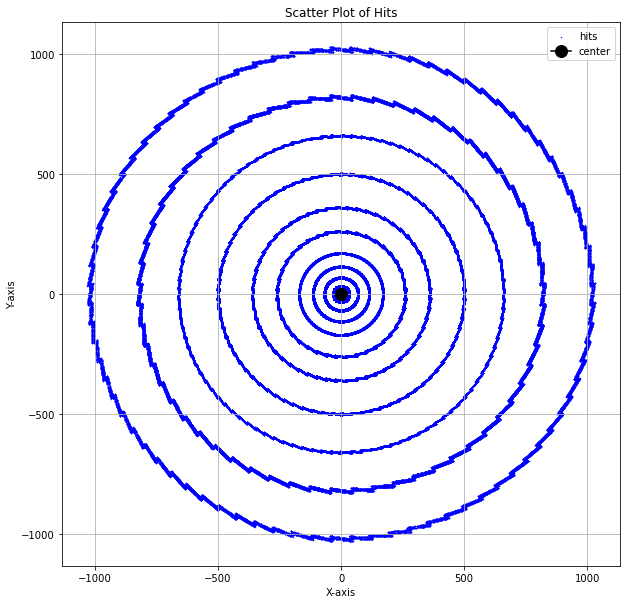

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Wed/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


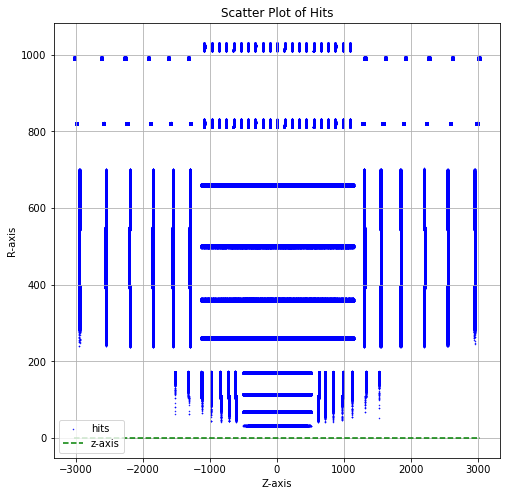

/tmp/ipykernel_489/2332433567.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  particles_sel = particles_sel[


true_tracks:  (198, 4)
phi:  -2.4039266 eta: 0.045360237  curvature:  -0.000548208511296309  vz:  26.299278


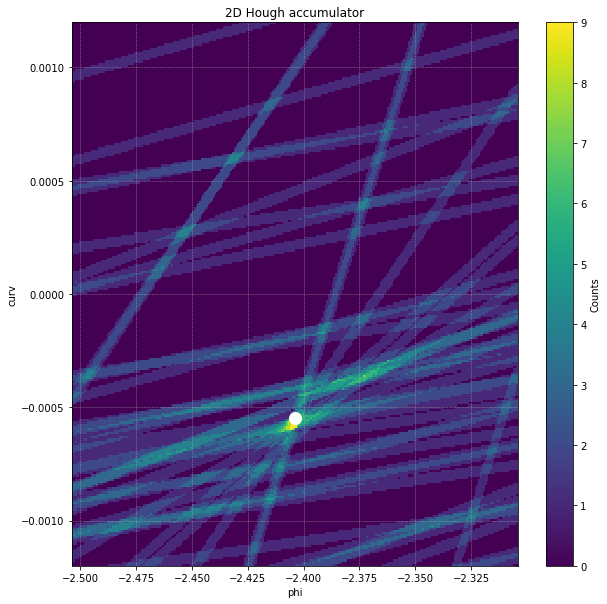

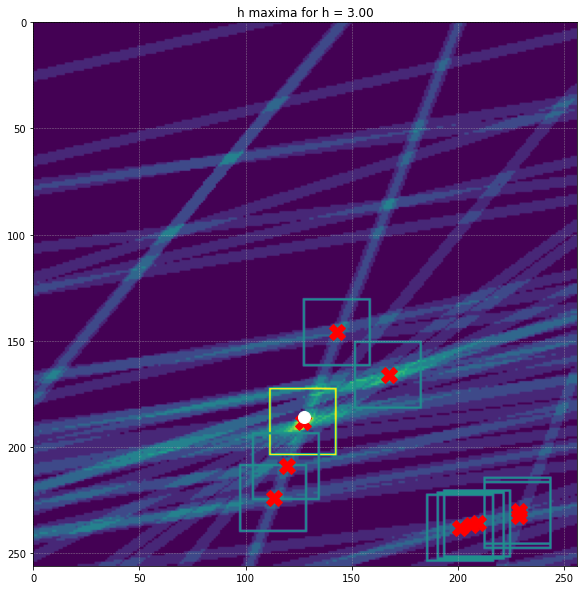

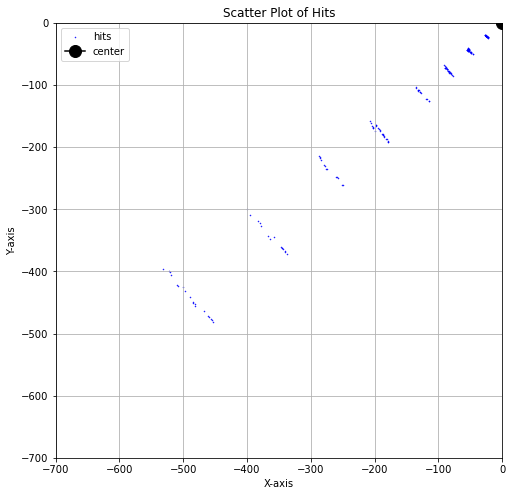

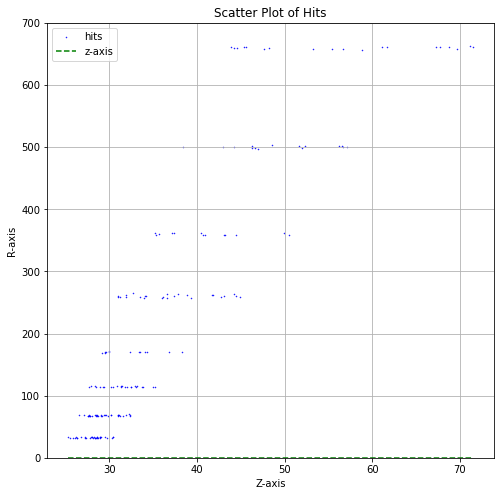

(256, 256)
phi:  2.799706 eta: 0.19954275  curvature:  -0.0004904334528649313  vz:  -58.701683


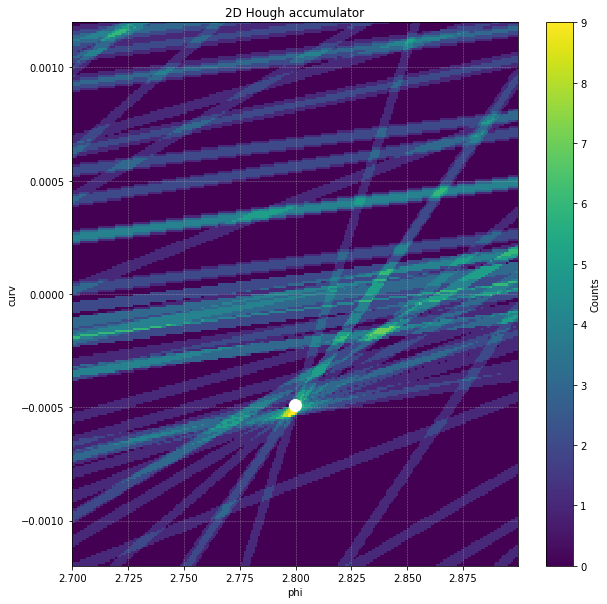

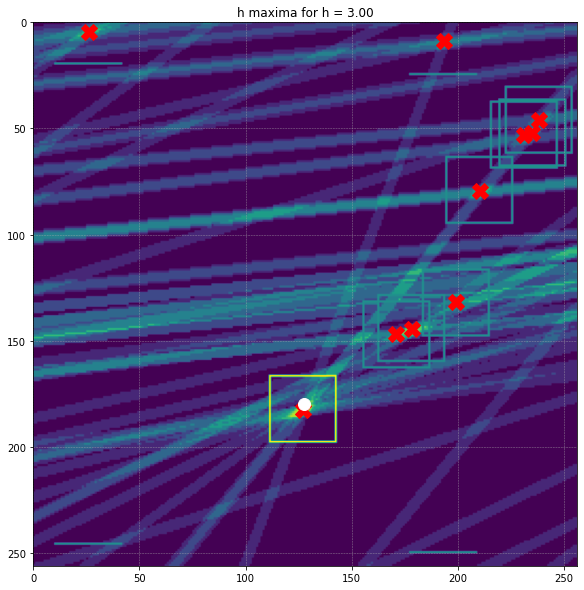

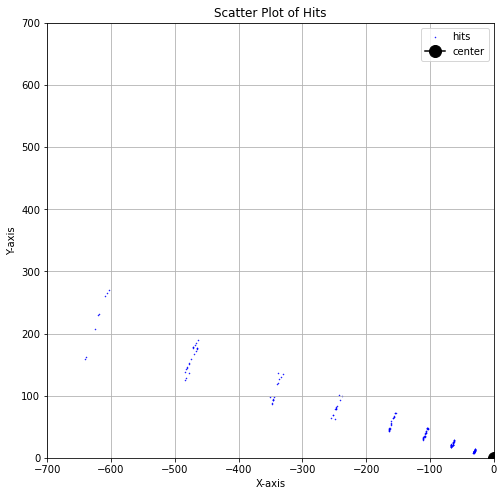

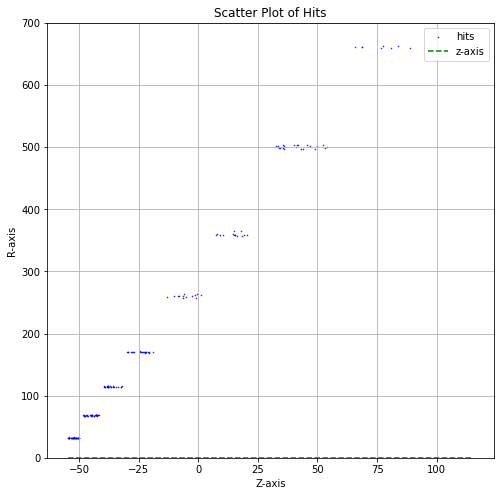

(256, 256)
phi:  -1.4404883 eta: 0.043521225  curvature:  0.00019837196809823052  vz:  -94.72694


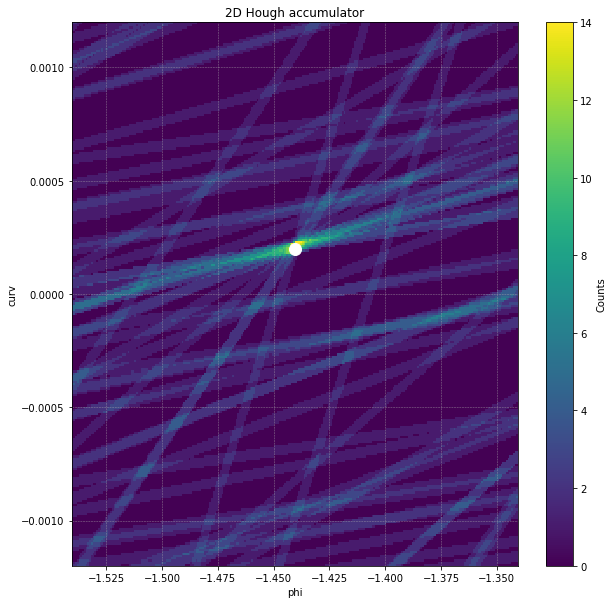

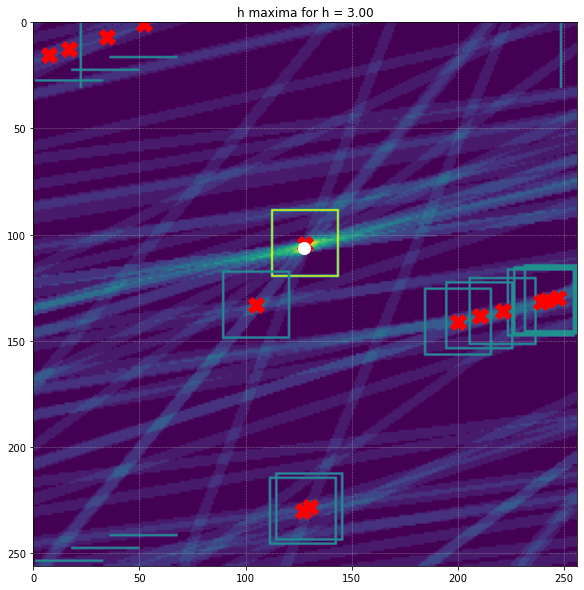

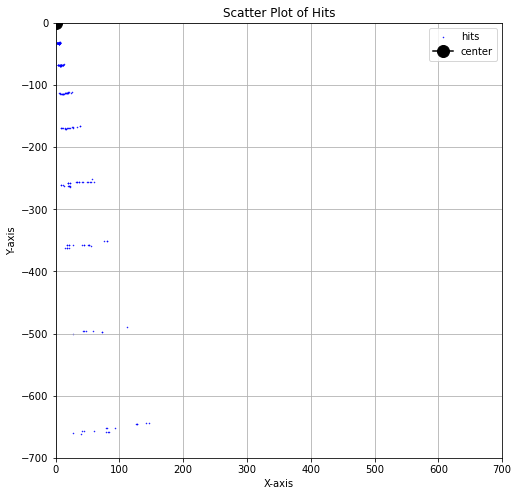

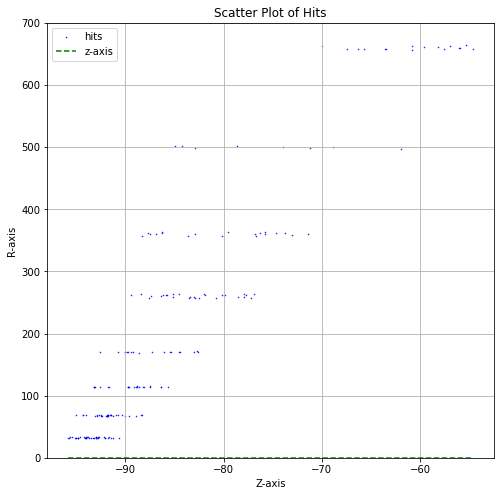

(256, 256)
phi:  -1.8899629 eta: 0.029419634  curvature:  -0.0003018449921256448  vz:  -94.72694


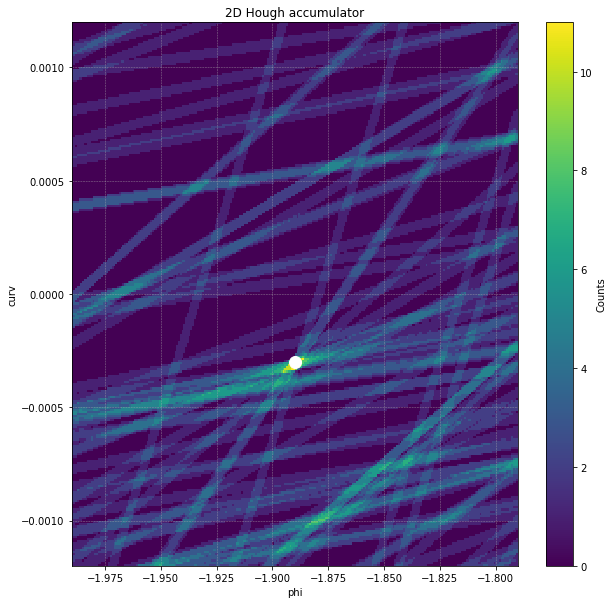

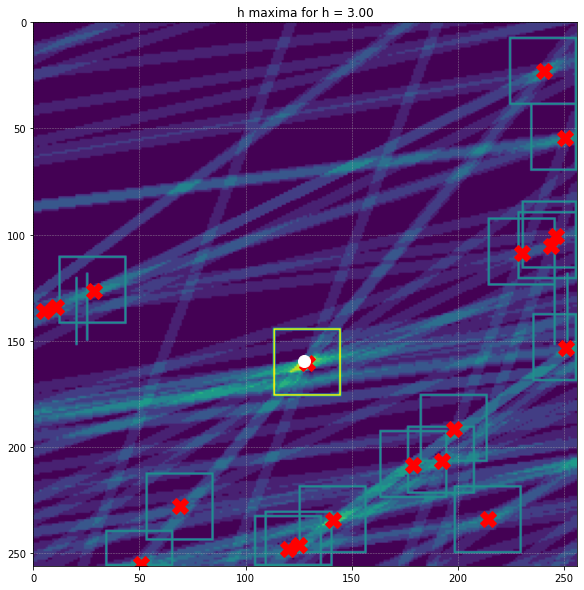

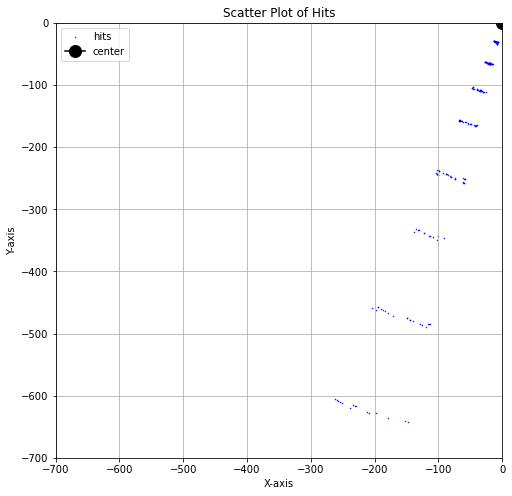

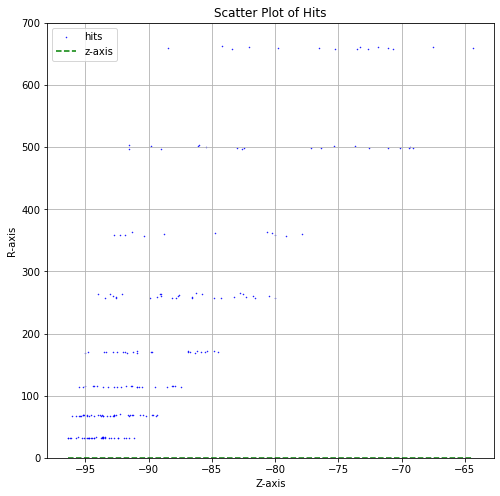

(256, 256)
phi:  1.4462706 eta: -0.010851918  curvature:  -0.000500855167020518  vz:  -12.665283


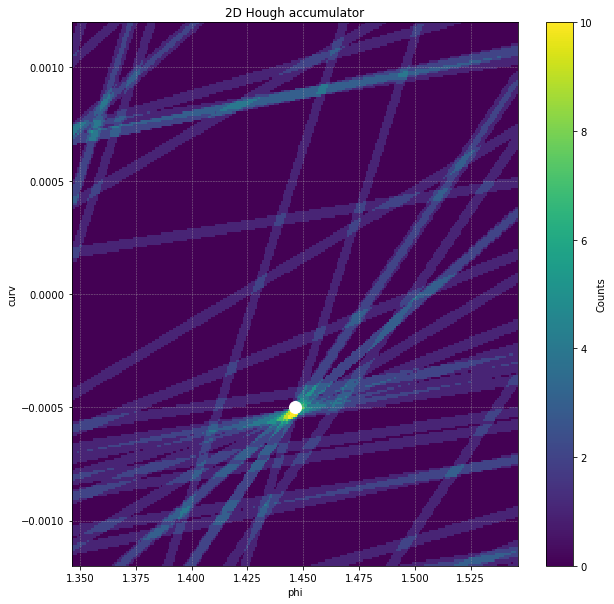

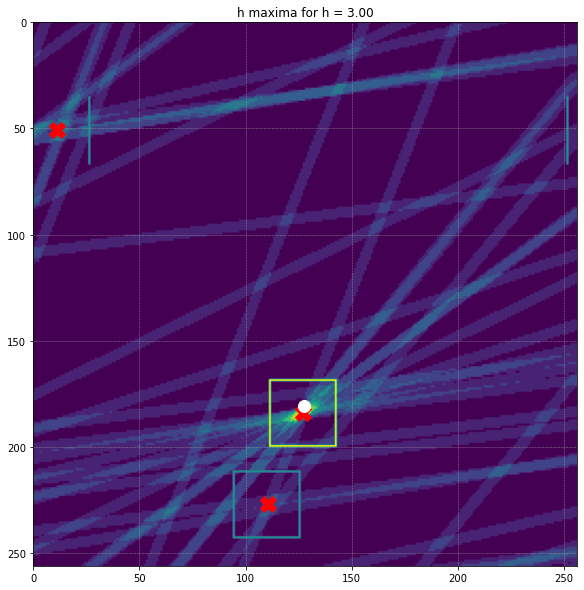

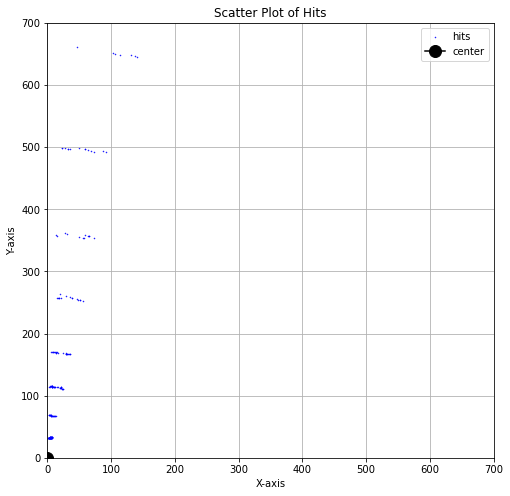

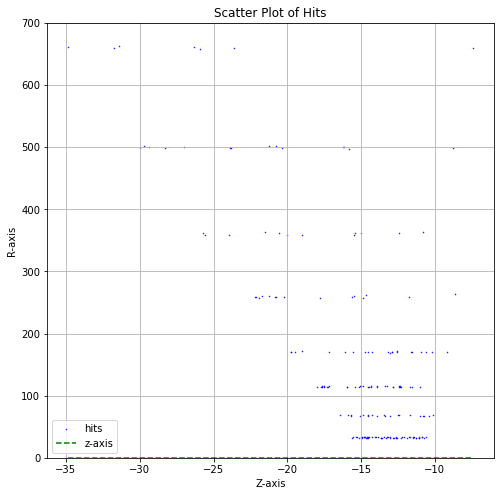

(256, 256)
phi:  -0.9396413 eta: 0.09348931  curvature:  -0.00032429387273677404  vz:  -12.621065


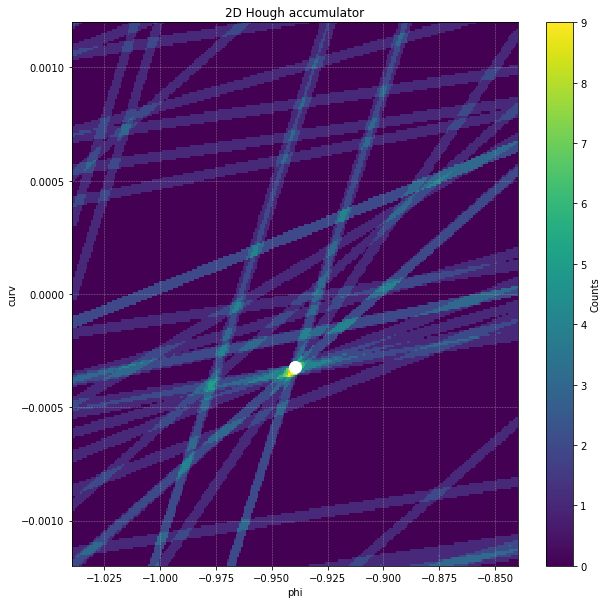

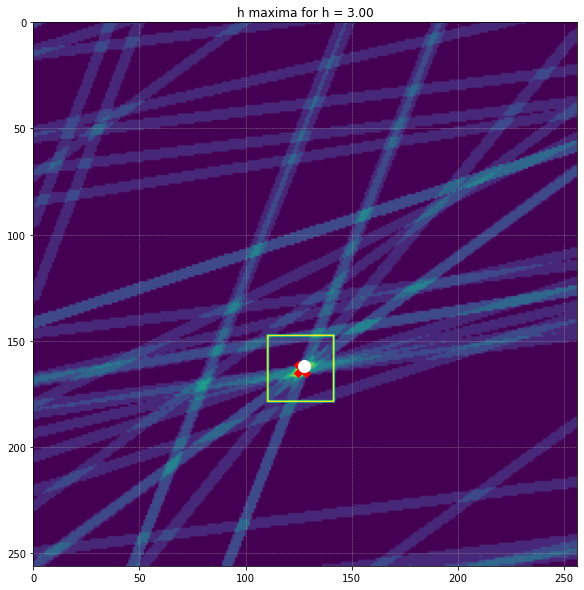

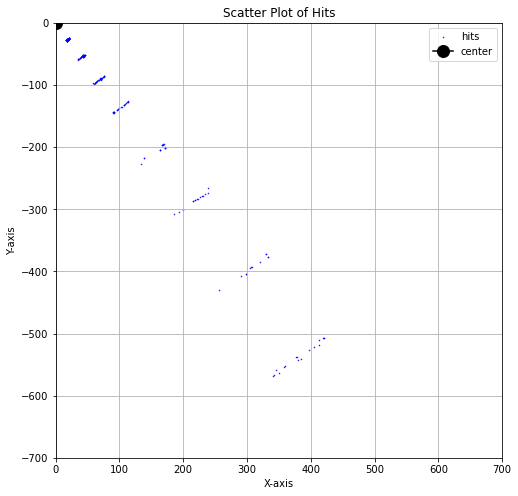

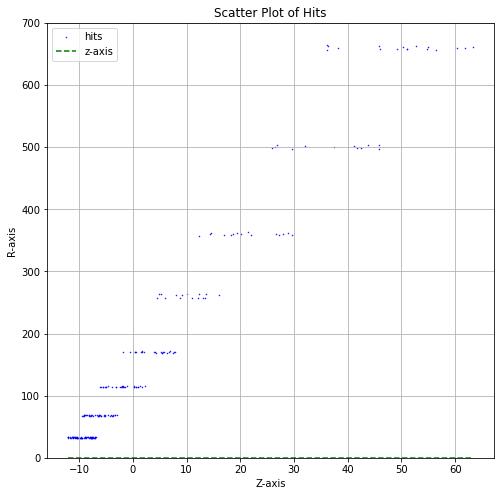

(256, 256)
phi:  -1.6351626 eta: -0.043894853  curvature:  0.0003895995984168553  vz:  97.62538


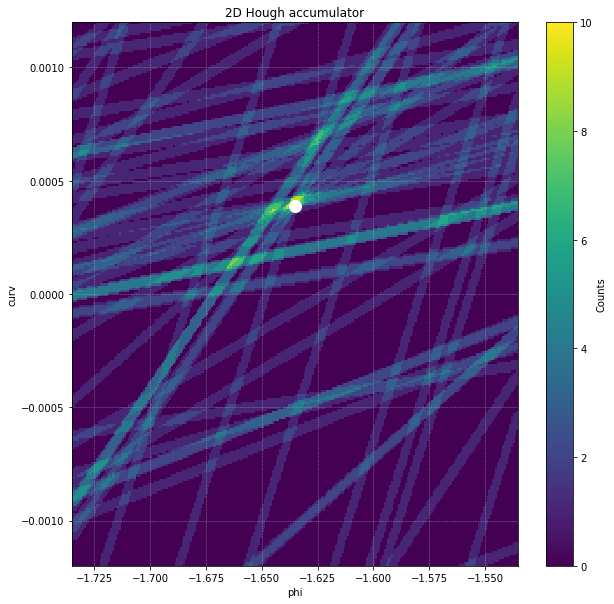

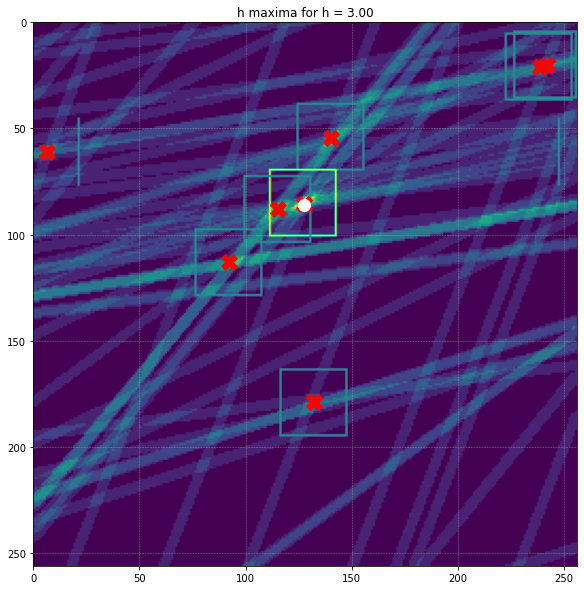

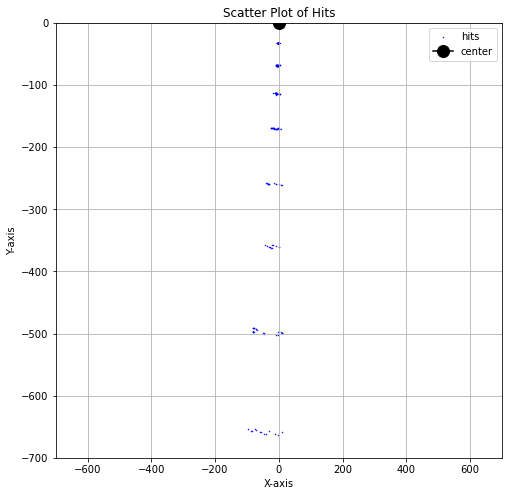

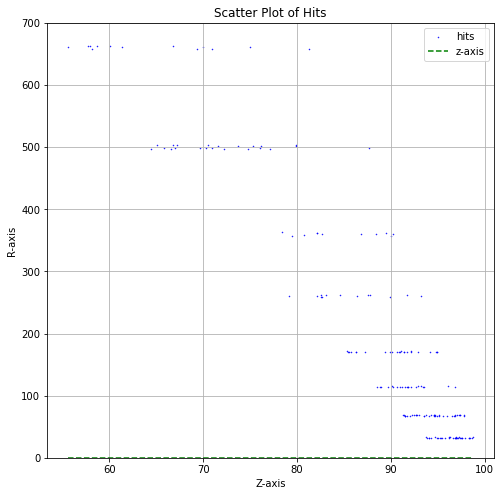

(256, 256)
phi:  -1.691964 eta: -0.089867145  curvature:  -0.0002934513012961349  vz:  97.62538


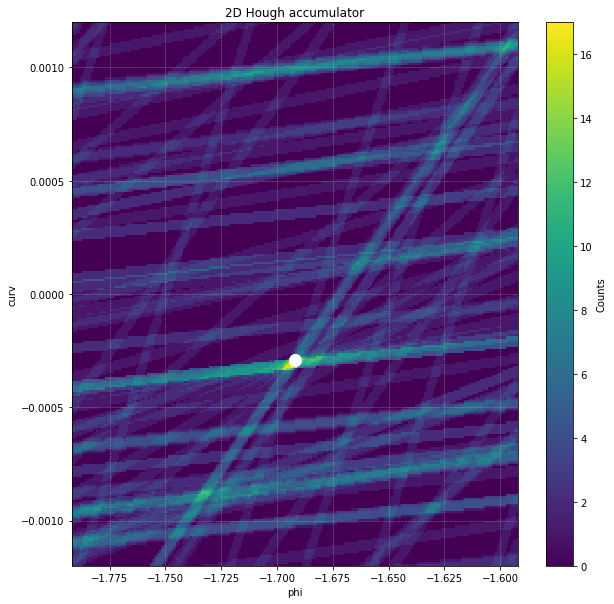

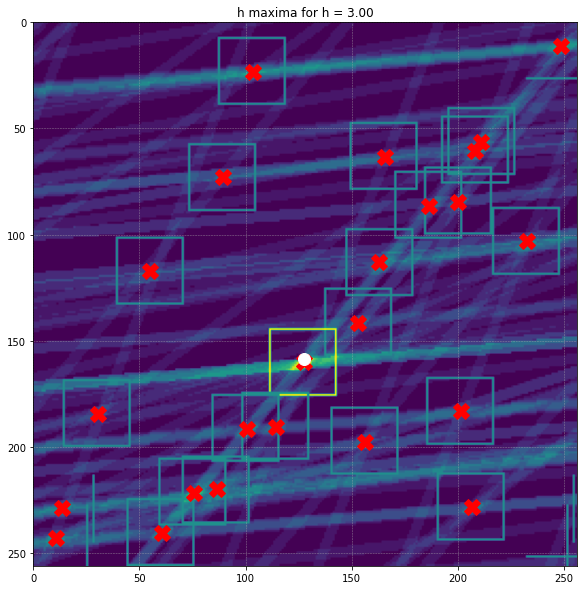

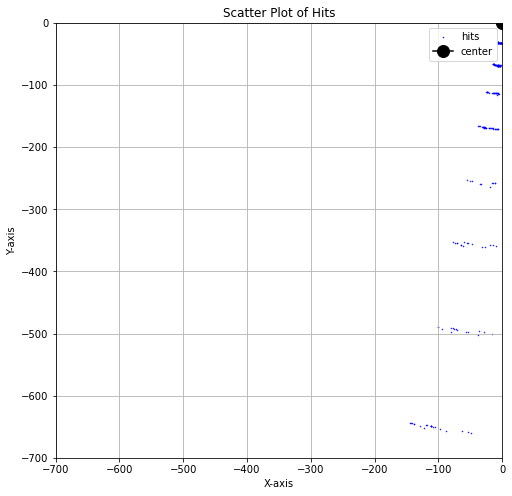

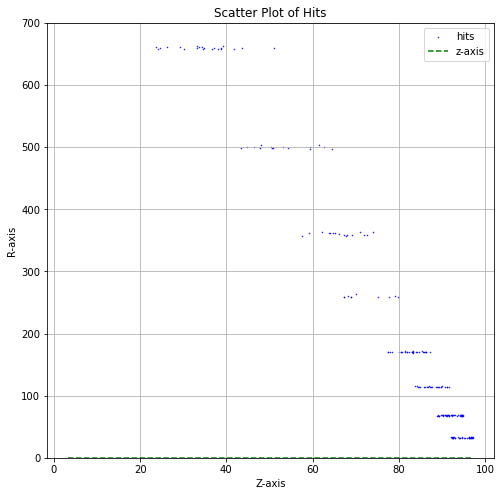

(256, 256)
phi:  2.2572992 eta: -0.14833562  curvature:  -0.0001660442773670027  vz:  94.57516


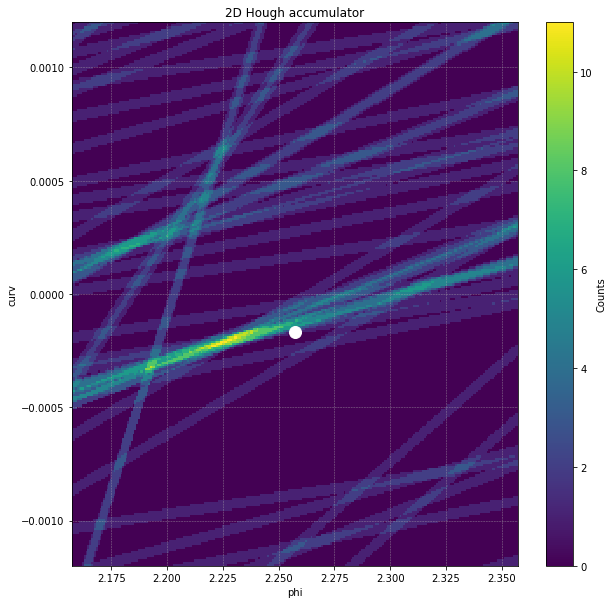

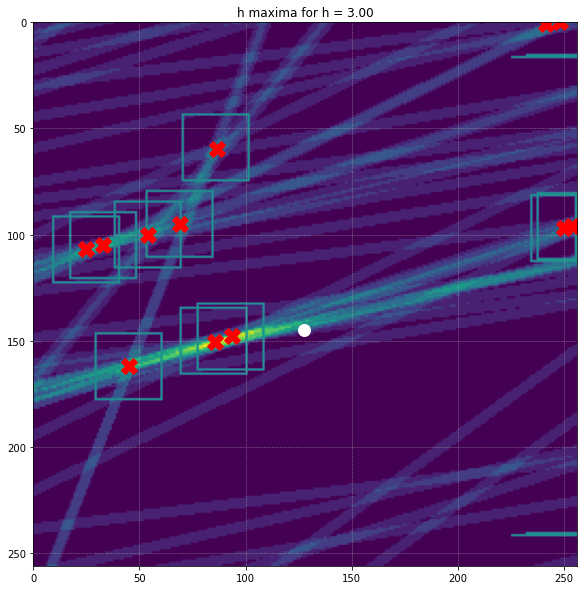

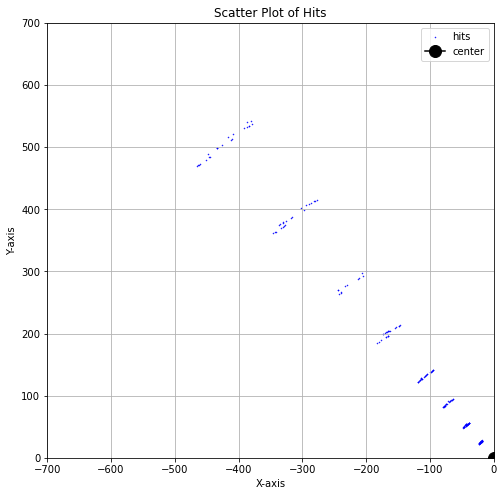

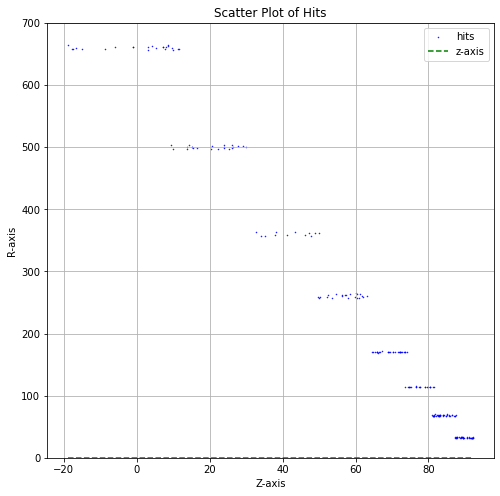

(256, 256)
phi:  1.9766765 eta: -0.16613199  curvature:  0.00021404705182293172  vz:  67.15404


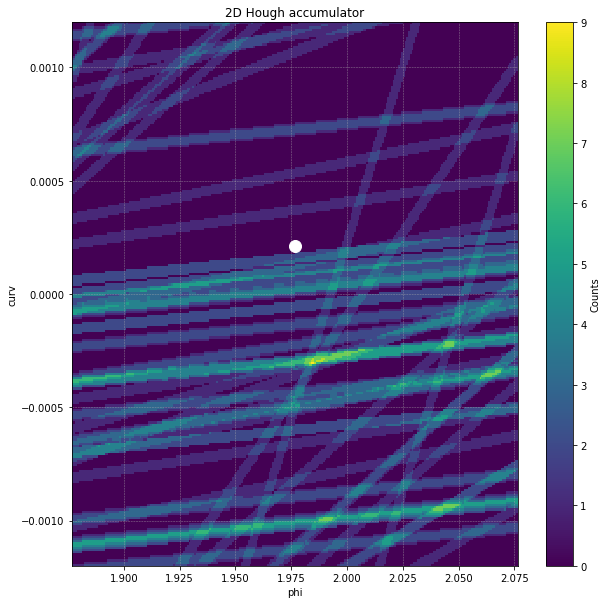

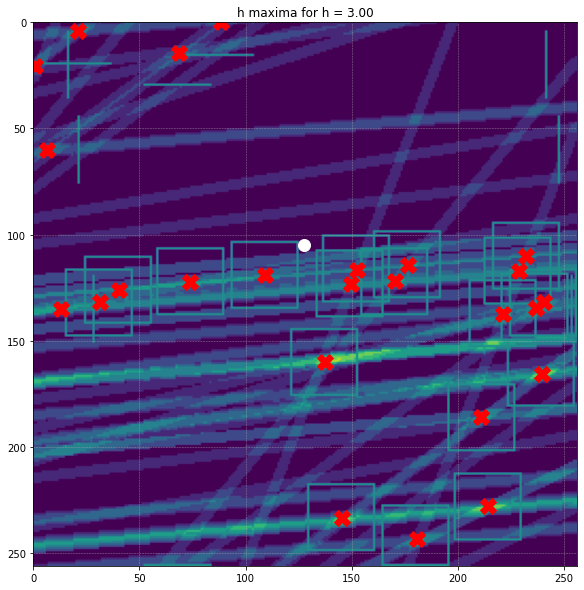

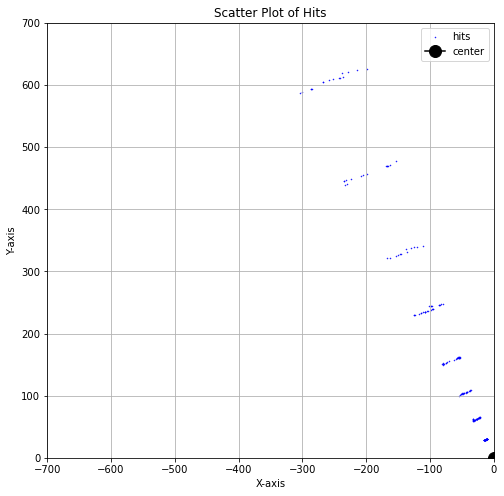

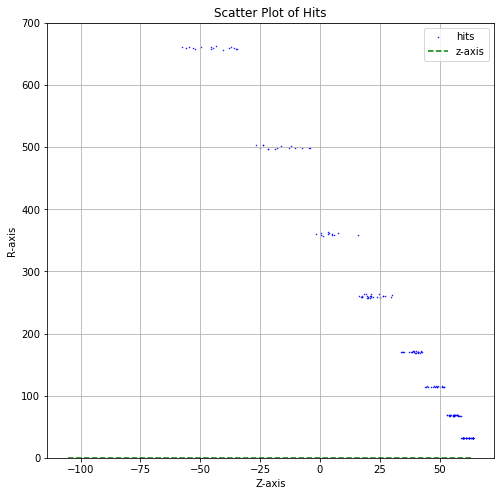

(256, 256)


In [60]:
#Plot few images
plot_hits_all(spacepoints)

for n in range(0,1):#(46,49):
    
    true_tracks = true_track(particles, n)
    print("true_tracks: ",true_tracks.shape)
    
    for k in range(min(true_tracks.shape[0], 10)):
        phi = true_tracks[k,0]
        eta = true_tracks[k,1]
        vz  = true_tracks[k,3]

        print("phi: ",true_tracks[k,0],"eta:",true_tracks[k,1]," curvature: ",true_tracks[k,2]," vz: ", true_tracks[k,3]) 
        
        

        lines, hough_space_hist, x_edges, y_edges = hough_track(spacepoints, n, phi, eta, vz) # fill hough accumulator

        #print(lines)
        #print(x_edges, y_edges)

        plt.figure(figsize=(10,10))
        plt.pcolormesh(x_edges, y_edges, hough_space_hist.T, cmap='viridis',shading='auto')  
        plt.xlim(x_edges[0], x_edges[-1])  # Explicitly set x-axis limits
        plt.ylim(y_edges[0], y_edges[-1])  # Explicitly set y-axis limits

        plt.colorbar(label='Counts')

        # Add grid
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        plt.xlabel('phi')
        plt.ylabel('curv')
        plt.title('2D Hough accumulator')
        
        # plot all the true maxima within phi, eta and vz range
        mask = (
        (abs(true_tracks[:, 0] - phi) < phi_tol) & 
        (abs(true_tracks[:, 1] - eta) < eta_tol) & 
        (abs(true_tracks[:, 3] - vz) < vz_tol)
        )  
        true_tracks_sel = true_tracks[mask]
        plt.plot(true_tracks_sel[:,0], true_tracks_sel[:,2], 'o', color='lightblue', markersize=10)
        plt.plot(true_tracks[k,0], true_tracks[k,2], 'wo', markersize=12)

        plt.show()


        img, img0, x, y, x_true, y_true, small_true, small_false = find_hough_maxima(hough_space_hist, true_tracks, height=height, 
                                                                                 phi=phi, eta=eta, vz=vz, tol = tollerance, N = small_size)

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        #print(overlay_h.shape)
        ax.imshow(img, cmap = "viridis", extent=[0, img.shape[1], img.shape[0], 0])
        # Remove extra whitespace around the image
        ax.set_xlim(0, img.shape[1])
        ax.set_ylim(img.shape[0], 0)
        
        ax.set_title(f'h maxima for h = {height:.2f}')
        ax.plot(x,y,"rX", markersize=16)
        ax.plot(x_true, y_true,'wo', markersize=12)
        # Add grid
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

        #ax.axis('off')
        plt.show()    
        
        plot_hits(spacepoints, n, phi, eta, vz, all=True)  # Plot the hits

        print(hough_space_hist.T.shape)
       

In [ ]:
'''
# a new figure with 3 subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#print(overlay_h.shape)
ax.imshow(img, cmap = "viridis")
ax.set_title(f'h maxima for h = {height:.2f}')
ax.plot(x_true, y_true,'wo', markersize=12)
ax.plot(x,y,"ro", markersize=12)

#ax.axis('off')
plt.show()
'''

In [ ]:
'''
# a new figure with 3 subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#print(overlay_h.shape)
ax.imshow(img0, cmap = "viridis")
ax.set_title(f'h maxima for h = {height:.2f}')
ax.plot(x_true, y_true,'wx')
ax.plot(x,y,"ro")

#ax.axis('off')
plt.show()
'''

In [ ]:
#visualize the TRUE maxima

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(min(len(small_true),100)):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(small_true[i], cmap=plt.cm.viridis, interpolation='nearest')
plt.show()

In [ ]:
#visualize the FALSE maxima

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(min(len(small_false),100)):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(small_false[i], cmap=plt.cm.viridis, interpolation='nearest')
plt.show()

In [ ]:
'''
images_true = []
images_false = []
for nn in range(num_events):
    # Generate tracks
    tracks, track_par = generate_curved_tracks(num_tracks, radii)
    # Fill Hough accumulator
    lines, hough_space_hist, x_edges, y_edges = hough_track(tracks)
    # Find Hough maxima
    img, img0, x, y, x_true, y_true, small_true, small_false = find_hough_maxima(hough_space_hist, track_par, height=height, tol = tollerance, N = small_size)
    
    #add images to output
    images_true = images_true + small_true
    images_false = images_false + small_false
    
'''

In [ ]:
images_true = []
images_false = []
for n in range(num_events):

    print("n event: ",n)
    
    true_tracks = true_track(particles, n)
    
    for k in range(true_tracks.shape[0]):

        print("k track: ",k) 

        phi = true_tracks[k,0]
        eta = true_tracks[k,1]
        vz  = true_tracks[k,3]

        lines, hough_space_hist, x_edges, y_edges = hough_track(spacepoints, n, phi, eta, vz)    

        img, img0, x, y, x_true, y_true, small_true, small_false = find_hough_maxima(hough_space_hist, true_tracks, height=height, 
                                                                             phi=phi, eta=eta, vz=vz, tol = tollerance, N = small_size)


        #add images to output
        images_true = images_true + small_true
        images_false = images_false + small_false

In [ ]:
# Convert the list of arrays into a single numpy array of shape (1000, 28, 28)
array_true = np.stack(images_true, axis=0)  # Stack along a new dimension
array_false = np.stack(images_false, axis=0)  # Stack along a new dimension

#add column with class
y_true = np.ones(array_true.shape[0])
y_false = np.zeros(array_false.shape[0])
print(array_true.shape, array_false.shape)

# Combine arrays along the 0 axis
combined_array = np.vstack((array_true, array_false))
y_combined = np.hstack((y_true, y_false))

# Save the array to disk
np.savez('images', X = combined_array, y = y_combined)

print("Shapes of output arrays: ",combined_array.shape, y_combined.shape)
